# Machine Learning to Predict Brittleness from other Geophysical Logs

## Data: 4 wells from the Appalachian Basin

In [21]:
import os
import pandas as pd

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor as gbR, GradientBoostingClassifier as gbC, IsolationForest
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.feature_selection import mutual_info_regression

pd.set_option('display.max_columns', None)   #to display all the column information
pd.options.display.max_seq_items = 2000

### Load data

In [2]:
# file_directory = r"C:\Users\tmo0005\Desktop\Thesis work\Thesis work\Well_Data_CSV_Merged"  #for lab computer

file_directory = r"../Thesis work/Thesis work/Well_Data_CSV_Merged"    #for macbook google drive

file_name1 = "Poseidon.csv"
file_name2 = "Boggess.csv"
file_name3 = "Mip3h.csv"
file_name4 = "Whipkey.csv"

file_name = [file_name1, file_name2, file_name3, file_name4]
data = []

for i in file_name:
    file_path = os.path.join(file_directory,i)
    df = pd.read_csv(file_path)
    data.append(df)

In [3]:
data_poseidon = data[0]
data_boggess = data[1]
data_mip3h = data[2]
data_whipkey = data[3]

In [4]:
print("The Poseidon data has {} rows".format(data_poseidon.shape[0]))
print("The Boggess data has {} rows".format(data_boggess.shape[0]))
print("The Mip3h data has {} rows".format(data_mip3h.shape[0]))
print("The Whipkey data has {} rows".format(data_whipkey.shape[0]))

The Poseidon data has 1910 rows
The Boggess data has 2851 rows
The Mip3h data has 2001 rows
The Whipkey data has 1141 rows


In [5]:
#making all the wells have the same shearwave sonic column name
# data_boggess['DTSM_SLOW'] = data_boggess.DTSH_SLOW
# data_mip3h['DTSM_SLOW'] = data_mip3h.DTSM

data_boggess.rename(columns={'DTSH_SLOW': 'DTSM_SLOW'}, inplace=True)
data_mip3h.rename(columns={'DTSM': 'DTSM_SLOW'}, inplace=True)

In [6]:
data_boggess.head(5)

,Unnamed: 0,DEPT,BMK_DYN,C33_TIV,C44_TIV,C55_TIV,C66_TIV,DTCO,DTSH_FAST,DTSH_HORI,DTSM_SLOW,FANG_PPC,GAMMA_TIV,GR_EDTC_x,PIGE_QE_x,PPGI,PPRS,PR_DYN,PR_HORZ,PR_VERT,RHOZ,RHOZ_REC_QE,SMG_DYN,SPHI,TSTR,TVD,TXSG_ISO,TXSG_TIV,TXSP_ISO,TXSP_TIV,TZSG,TZSP,UCS_YME,VCL_GEO_QE_x,YME_DYN,YME_HORZ,YME_HORZ_STATIC,YME_STATIC,YME_VERT,YME_VERT_STATIC,ADSORBEDGIP_SG,APP_THICK_PAY_SG,APP_THICK_RES_SG,ASAL_INCP,BOUND_WATER_QE,BS,BVIRR_GEO_QE,CALCITE_QE,CHLORITE_QE,CS,CUMADSORBGIP_SG,CUMFREEGIP_SG,CUMGIP_SG,DATA_PERM_SG,DATA_PHI_SG,DATA_SHYD_SG,DATA_SW_SG,DATA_TOC_SG,DATA_VGAS_SG,DOLOMITE_QE,DPH8,DPHI_EDIT,DPHZ,DRY_WEIGHT_CALCITE_QE,DRY_WEIGHT_CHLORITE_QE,DRY_WEIGHT_DOLOMITE_QE,DRY_WEIGHT_ILLITE_QE,DRY_WEIGHT_KEROGEN_QE,DRY_WEIGHT_PYRITE_QE,DRY_WEIGHT_QUARTZ_QE,DSO8,DSOZ,DWAL_INCP,DWCA_INCP,DWFE_INCP,DWGD_INCP,DWK_INCP,DWMG_INCP,DWMN_INCP,DWN_INCP,DWNA_INCP,DWP_INCP,DWSI_INCP,DWSU_INCP,DWTC_INCP,DWTI_INCP,DWTIC_INCP,DWTOC_INCP,ECGR_EC,FPRESS,FREEGIP_SG,FTEMP,GIP_SG,GR,GR_EDTC_y,GTEM,HCAL,HCGR,HCGR_EC,HDRA,HFK,HFK_EC,HSGR,HSGR_EC,HTHO,HTHO_EC,HURA,HURA_EC,ILLITE_QE,KEROGEN_QE,KGAS_SG,KINT_SHALE_SG,KWTR_SG,MRP_UNC_T1,MRP_UNC_T1_EDIT,NPHI,NPHU_EC,PAY_FLAG_SG,PEF8,PEFZ,PEGE_INCP,PHIT_QE,PIGE_QE_y,PIGN_QE,PYRITE_QE,QUARTZ_QE,RES_FLAG_SG,RHGA_GEO_QE,RHGE_INCP,RHO8,RHOZ_y,RHOZ_EDIT,RLA0,RLA1,RLA2,RLA3,RLA4,RLA5,RM_HRLT,RSO8,RSOZ,RXO8,RXOZ,SIGE_INCP,SIGM,SW_QE,SWE_QE,SXO_QE,TENS,TNGE_INCP,TNPH,TNPH_EC,U8,UGAS_QE,UGE_INCP,UWATER_QE,UZ,VCL_GEO_QE_y,WANH_INCP,WCLA_INCP,WCLC_INCP,WCOA_INCP,WDOL_INCP,WEVA_INCP,WPYR_INCP,WQFM_INCP,WSID_INCP,XGAS_QE,XWATER_QE,Brittleness,Brittleness_new,Brittleness_mod
0,0,6905.0,4.077845,6.540266,1.856273,1.846815,2.494646,74.4156,140.0393,120.4917,139.6821,29.43957,0.175391,194.1577,0.040750,0.68,4695.092,0.303256,0.246245,0.276543,2.702412,2.687895,1.846815,0.1902,956.4602,6904.547,0.938249,0.956790,6478.182,6606.200,1.166346,8053.091,11477.52,0.380543,4.813747,6.217879,3.714147,2.705687,4.832736,2.718903,8.398603,84.5,338.5,163.382163,0.015248,8.5,0.020550,0.027306,0.062950,443.5081,40.91793,141.0805,181.9984,NaN,4.074983,18.17808,81.82192,NaN,0.007408,0.000000,-0.003642,0.004437,0.004437,0.028222,0.077527,0.000000,0.321396,0.006148,0.046339,0.520368,-0.05118,0.264666,0.081275,0.011483,0.061531,8.203081,0.023411,0.005932,0.0,0.004110,0.003245,0.0,0.278362,0.025951,0.008762,0.007241,0.003442,0.005320,181.2986,4695.40,26.208990,130.1450,34.607590,170.0893,170.5613,130.1450,9.766923,109.16140,108.88040,0.138168,3.308638,3.301515,165.6663,166.7665,15.61549,15.56714,6.843022,6.868026,0.302996,0.012352,NaN,1.000000e-07,NaN,0.135263,0.135263,0.245579,0.188556,0.0,1.834761,3.864211,3.704671,0.055170,0.039923,0.039923,0.024349,0.514875,0.0,2.775133,2.789289,2.716228,2.702412,2.702412,0.025009,11.098530,20.17830,24.44393,25.34963,25.80840,0.029433,0.083725,0.090259,1.034335,1.733814,29.081112,37.12511,0.648852,0.514736,0.717267,3926.600,0.114717,0.210172,0.188556,4.978619,0.019373,10.305484,0.020550,10.43565,0.381194,0.0,0.399059,0.028679,0.0,0.000000,0.0,0.048552,0.523709,0.0,0.015598,0.024324,0.496920,0.135660,0.104883
1,1,6905.5,4.040899,6.508460,1.847365,1.850671,2.431576,74.4180,139.5573,121.7512,139.6821,30.13020,0.156945,184.2624,0.041061,0.68,4695.432,0.301336,0.249701,0.276862,2.704231,2.674996,1.850671,0.1902,957.1836,6905.047,0.936001,0.952325,6463.133,6575.848,1.166346,8053.677,11486.20,0.361395,4.816688,6.077487,3.610632,2.707733,4.837870,2.722478,11.134880,84.5,338.5,163.093936,0.014526,8.5,0.020165,0.009265,0.074981,466.5875,40.90806,141.0497,181.9577,NaN,4.106147,19.49867,80.50133,NaN,0.008006,0.000000,-0.003642,0.003374,0.003374,0.009594,0.092521,0.000000,0.290824,0.008366,0.038434,0.560261,-0.05118,0.272187,0.078063,0.004074,0.060639,7.845018,0.022588,0.007970,0.0,0.003203,0.003378,0.0,0.288926,0.022270,0.008419,0.007192,0.001221,0.007198,178.6354,4695.74,28.310000,130.1495,39.444880,168.5123,173.1383,130.1495,9.627731,108.20810,107.65800,0.143037,3.274404,3.267048,164.3859,165.4737,15.51036,15.37711,6.820299,6.87

# Input and Output of the Model

### Data for Regression task

In [29]:
data = pd.concat([data_whipkey, 
                  data_boggess,
                  data_poseidon], ignore_index=True)

In [30]:
features =  ['DEPT', 'GR', 'NPHI','RHOZ', 'HCAL', 'DTCO','PEFZ', 'Brittleness_new','DTSM_SLOW']   #list of the features names to select
target = 'DTSM_SLOW'   #name of the output feature
data = data.loc[: ,features]

In [31]:
data.dropna(inplace = True)

In [32]:
data.shape

(5902, 9)

In [33]:
#add correlation plot
data.corr(method = 'pearson')

,DEPT,GR,NPHI,RHOZ,HCAL,DTCO,PEFZ,Brittleness_new,DTSM_SLOW
DEPT,1.000000,-0.233646,-0.634200,-0.597748,-0.115878,-0.169500,-0.147139,0.648853,-0.476042
GR,-0.233646,1.000000,0.674827,-0.287876,0.057285,0.732398,0.247037,-0.618851,0.751253
NPHI,-0.634200,0.674827,1.000000,0.159263,0.044760,0.779093,0.317245,-0.881913,0.907424
RHOZ,-0.597748,-0.287876,0.159263,1.000000,0.104695,-0.366538,0.279979,-0.250155,-0.051413
HCAL,-0.115878,0.057285,0.044760,0.104695,1.000000,0.012778,0.062860,-0.206485,0.153763
DTCO,-0.169500,0.732398,0.779093,-0.366538,0.012778,1.000000,0.258972,-0.675451,0.906852
PEFZ,-0.147139,0.247037,0.317245,0.279979,0.062860,0.258972,1.000000,-0.475774,0.386749
Brittleness_new,0.648853,-0.618851,-0.881913,-0.250155,-0.206485,-0.675451,-0.475774,1.000000,-0.899657
DTSM_SLOW,-0.476042,0.751253,0.907424,-0.051413,0.153763,0.906852,0.386749,-0.899657,1.000000


In [34]:
def StatRelat(data, target):
    #Mutual information and Pearson's corelation for measuring the dependency between the variables.
    """
    function to estimate the Mutual information and Pearson's corelation 
    for measuring the dependency between the variables.
    
    Parameters
    ----------
    data : DataFrame
        The data 
    target: Str
        The column name of the target feature
        
    Returns
    -------
    A histogram of mutual information and heatmap of correlation between features
    """
    df2 = data.copy().dropna()
    X = df2.drop([target], axis=1)._get_numeric_data()   # separate DataFrames for predictor and response features
    y = df2.loc[:,[target]]._get_numeric_data()

    mi = mutual_info_regression(X,np.ravel(y), random_state=20) # calculate mutual information
    mi /= np.max(mi)                          # calculate relative mutual information

    indices = np.argsort(mi)[::-1]            # find indicies for descending order

    print("Feature ranking:")                 # write out the feature importances
    for f in range(X.shape[1]):
        print("%d. feature %s = %f" % (f + 1, X.columns[indices][f], mi[indices[f]]))

    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15, 7))
#     fig.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.2, hspace=0.2)
    
    ax[0].bar(range(X.shape[1]), mi[indices],color="g", align="center")
    ax[0].set_title("Mutual Information")
    ax[0].set_xticks(range(X.shape[1]))
    ax[0].set_xticklabels(X.columns[indices],rotation=90)
    ax[0].set_xlim([-1, X.shape[1]])
    
    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    mask = np.zeros_like(df2.corr())
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        sns.heatmap(df2.corr(), mask=mask,cmap=cmap, vmax=.3, ax=ax[1], square=True, annot = True)
        ax[1].set_yticklabels(ax[1].get_yticklabels(), rotation=45)
    
    
#     fig.savefig(r'./Images/{}.png'.format('feature_selection'), dpi=300)

Feature ranking:
1. feature DEPT = 1.000000
2. feature DTCO = 0.843502
3. feature Brittleness_new = 0.842698
4. feature GR = 0.644248
5. feature NPHI = 0.605935
6. feature HCAL = 0.569847
7. feature PEFZ = 0.350472
8. feature RHOZ = 0.264281


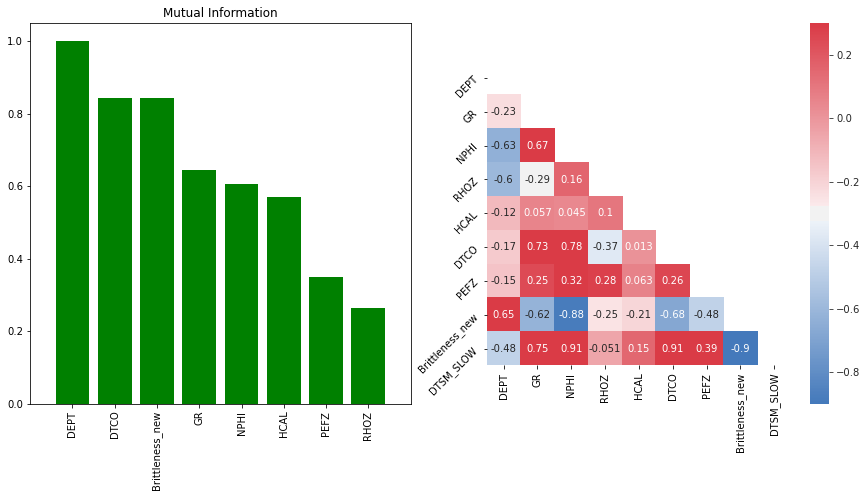

In [35]:
StatRelat(data, target)

In [36]:
# !pip install plotly
# !pip install -U kaleido

In [37]:
# import plotly.graph_objects as go

In [38]:
# # Matrix Scatter Plot to check for colinearity

# dimensions=[]
# for cols in data.columns:
#     if cols=='Brittleness':
#         pass
#     else:
#         x = dict(label=cols,
#                  values=df[cols])
#         dimensions.append(x)

# fig = go.Figure(data=go.Splom(
#                 dimensions=dimensions,
#                 showupperhalf=False,  # remove plots on upper diagonal to avoid repetition
#                 diagonal_visible=False,
#                 text=data['Brittleness'],
#                 marker=dict(
#                     opacity=0.8,
#                     color=data['Brittleness'],
#                     showscale=True,
#                     colorscale='RdGy',
#                     colorbar=dict(
#                     title='Brittleness'
#                     ),
#                 ),
#                 ))
                
# fig.update_layout(
#     title='Matrix Scatter Plot',
#     width=1200,
#     height=1200,
#     template='plotly_white'
# )

# fig.write_image(r'./Images/{}.png'.format('scatter_plot'))

In [39]:
data_summary = data.describe().T
# data_summary.to_excel(r'./Images/{}.xlsx'.format('data_summary_before_stand'))

In [40]:
#range
data_summary['max'] - data_summary['min']

DEPT               1590.000000
GR                  756.553600
NPHI                  0.385252
RHOZ                  0.822975
HCAL                  2.759490
DTCO                 55.887600
PEFZ                  7.424568
Brittleness_new       0.870199
DTSM_SLOW            93.331000
dtype: float64

In [41]:
#standard deviation
data.std()

DEPT               379.868044
GR                  61.422944
NPHI                 0.071080
RHOZ                 0.073869
HCAL                 0.488411
DTCO                10.578906
PEFZ                 0.636101
Brittleness_new      0.142104
DTSM_SLOW           18.259132
dtype: float64

In [42]:
scaler = StandardScaler()
data_norm = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
data_norm_summary = data_norm.describe().T
# data_norm_summary.to_excel(r'./Images/{}.xlsx'.format('data_summary_after_stand'))

In [43]:
data_norm.std()

DEPT               1.000085
GR                 1.000085
NPHI               1.000085
RHOZ               1.000085
HCAL               1.000085
DTCO               1.000085
PEFZ               1.000085
Brittleness_new    1.000085
DTSM_SLOW          1.000085
dtype: float64

In [52]:
X = data.drop(['DEPT','RHOZ','Brittleness_new',target], axis=1)
y = data.loc[:,[target]]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 1)

In [53]:
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)
# select all rows that are not outliers
mask = yhat != -1
X_train, y_train = X_train[mask], y_train[mask]
# summarize the shape of the updated training dataset
print(X_train.shape, y_train.shape)

(4249, 5) (4249, 1)


In [54]:
df = data_mip3h.loc[: ,features].dropna()
X_blind = df.drop(['DEPT','RHOZ','Brittleness_new',target], axis=1)
y_blind = df.loc[:,[target]]

In [55]:
X_train.shape

(4249, 5)

In [56]:
X_blind.shape

(1998, 5)

## Model Building

In [57]:
def modelfit(X_train, X_test, X_blind, y_train, y_test, y_blind, algorithm, hyper_parameters, scaler, classification,printFeatureImportance=True, cv_folds=3):
    """
    function to tune the gradient boosting model and return the optimum
    
    Parameters
    ----------
    X_train : DataFrame
        The input features for the training set
    X_test : DataFrame
        The input features for the testing set
    X_blind : DataFrame
        The input features for the blind set
    y_train : DataFrame 
        The output feature for the training set
    y_test : DataFrame 
        The output feature for the testing set
    y_blind : DataFrame 
        The output feature for the blind set
    algorithm : {'neural','svm','gradientboosting'}
        The Machine Learning model 
    hyper_parameters : dict
        A dictionary of the hyperparameters of the models that will be tuned
    scaler : {'standard','minmax'}
        Scaling technique to employ.
    classification : bool 
        Flag to specify the modeling technique. True for classification and False for regression
    printFeatureImportance : bool
        Flag to specify if to display the feature importance histogram.
    cv_folds : int
        Number of cross-validation folds. default is 3.
    
    Returns
    -------
    model : an object of the trained gradient boosting which can be deployed or saved
    """   
    #step to assign the selected standardaziation 
    if scaler == 'standard':
        scaler = StandardScaler()
    elif scaler == 'minmax':
        scaler =MinMaxScaler()
    else:
        print("invalid scaler: use 'standard' or 'minmax'")
        
    
    #step to assign the selected machine learning algorithm
    if algorithm == 'svm':
        if classification is True:
            algo = SVC(random_state=83)
        else:
            algo = SVR()
        
    elif algorithm == 'neural':
        if classification is True:
            algo = MLPClassifier(random_state=677)
        else:
            algo = MLPRegressor(random_state=134)
    
    elif algorithm == 'gradientboosting':
        if classification is True:
            algo = gbC(random_state=10)
        else:
            algo = gbR(random_state=824)
    else:
        print("invalid scaler: use 'svm' or 'neural' or 'gradientboosting'")
    
     
        
    if classification is True:
        pipe = Pipeline(steps=[('scaler', scaler), ('model', algo)])
        model = GridSearchCV(estimator = pipe,
                             param_grid = hyper_parameters,
                             scoring='accuracy',n_jobs=-1, cv=cv_folds, verbose = 1)
        
        #Fit the model on the data
        model.fit(X_train.values, y_train.values.ravel())

        #Predict training set:
        y_train_pred = model.predict(X_train)

        #Predict testing set:
        y_test_pred = model.predict(X_test)
        
        #Predict blind set
        y_blind_pred = model.predict(X_blind)

        #Print model report:
        print("Model Report")
        print("-------------------------------")
        print("The training accuracy : {0:.4g}".format(metrics.accuracy_score(y_train.values, y_train_pred)))
        print("The testing accuracy is : {0:.4g}".format(metrics.accuracy_score(y_test.values,y_test_pred)))
        print("The blind well accuracy is : {0:.4g}".format(metrics.accuracy_score(y_blind.values,y_blind_pred)))
        print("CV best score : {0:.4g}".format(model.best_score_))
        print("CV best parameter combinations : {}".format(model.best_params_))
        
        if algorithm == 'gradientboosting':
            #Print Feature Importance:
            if printFeatureImportance:
                feat_imp = pd.Series(model.best_estimator_.named_steps.model.feature_importances_, X_train.columns).sort_values(ascending=False)
                feat_imp.plot(kind='barh', title='Feature Importances')
                plt.xlabel('Feature Importance Score')
           
    else:
        pipe = Pipeline(steps=[('scaler', scaler), ('model', algo)])
        model = GridSearchCV(estimator = pipe,
                             param_grid = hyper_parameters,
                             scoring='r2',n_jobs=-1,
                             cv=cv_folds, verbose = 1)
        
        #Fit the model on the data
        model.fit(X_train.values, y_train.values.ravel())

        #Predict training set:
        y_train_pred = model.predict(X_train)

        #Predict testing set:
        y_test_pred = model.predict(X_test)
                        
        #Predict blind set
        y_blind_pred = model.predict(X_blind)

        #Print model report:
        print("Model Report")
        print("-------------------------------")
        print("The training R2 score : {0:.4g}".format(metrics.r2_score(y_train.values, y_train_pred)))
        print("The testing R2 score is : {0:.4g}".format(metrics.r2_score(y_test.values,y_test_pred)))
        print("The blind well R2 score is : {0:.4g}".format(metrics.r2_score(y_blind.values,y_blind_pred)))
        print("CV best score : {0:.4g}".format(model.best_score_))
        print("CV best parameter combinations : {}".format(model.best_params_))
        
        if algorithm == 'gradientboosting':
            #Print Feature Importance:
            if printFeatureImportance:
                feat_imp = pd.Series(model.best_estimator_.named_steps.model.feature_importances_, X_train.columns).sort_values(ascending=False)
                feat_imp.plot(kind='barh', title='Feature Importances')
                plt.xlabel('Feature Importance Score')

    return model.best_estimator_


## Training the Gradient Boosting

In [58]:
#use the documentation of SVR() to understand the parameters
#put new parameters in the grid by using "model__" before the parameter name as below
hyper_parameters =  {"model__min_samples_split" : [3],
                     "model__min_samples_leaf": [1,2,3],
                     "model__max_depth"        : [3, 4, 5,6,7,8,]
                    }

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   11.4s finished


Model Report
-------------------------------
The training R2 score : 0.9929
The testing R2 score is : 0.9766
The blind well R2 score is : 0.9576
CV best score : 0.9707
CV best parameter combinations : {'model__max_depth': 7, 'model__min_samples_leaf': 2, 'model__min_samples_split': 3}


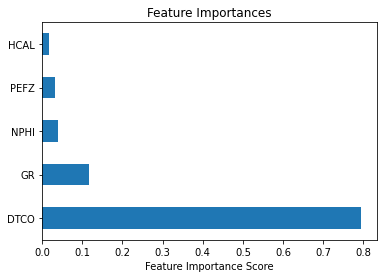

In [59]:
model_gb = modelfit(X_train, X_test, X_blind, y_train, y_test, y_blind, algorithm='gradientboosting', 
             hyper_parameters=hyper_parameters, scaler='standard', 
             classification=False,printFeatureImportance=True, cv_folds=3)

In [60]:
y_train_pred = model_gb.predict(X_train)

Vp = 116.08 / X_train.DTCO
Vs = 116.08 / y_train_pred
Rhob = X_train.RHOZ

v = (Vp**2 - 2*Vs**2) / (2*(Vp**2 - Vs**2))
E = (Rhob * Vs**2 * (3*Vp**2 - 4*Vs**2)) / (Vp**2 - Vs**2)
YM_brit = (E-E.min())/(E.max()-E.min())
v = 1/v
PR_brit = (v-v.min())/(v.max()-v.min())

brit_pred = (YM_brit + PR_brit) / 2

Vp = 116.08 / X_train.DTCO
Vs = 116.08 / y_train.DTSM_SLOW
Rhob = X_train.RHOZ

v = (Vp**2 - 2*Vs**2) / (2*(Vp**2 - Vs**2))
E = (Rhob * Vs**2 * (3*Vp**2 - 4*Vs**2)) / (Vp**2 - Vs**2)
YM_brit = (E-E.min())/(E.max()-E.min())
v = 1/v
PR_brit = (v-v.min())/(v.max()-v.min())

brit = (YM_brit + PR_brit) / 2

AttributeError: 'DataFrame' object has no attribute 'RHOZ'

In [21]:
metrics.r2_score(brit,brit_pred)

0.9946820155766624

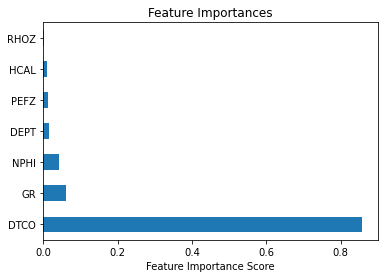

In [44]:
feat_imp = pd.Series(model_gb.named_steps.model.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='barh', title='Feature Importances')
plt.xlabel('Feature Importance Score')
# plt.savefig(r'./Images/{}.png'.format('gb_feature_importance'), dpi=300)

In [40]:
# model2 = modelfit(X_train2, X_test2, X_blind2, y_train2, y_test2, y_blind2, algorithm='gradientboosting', 
#              hyper_parameters=hyper_parameters, scaler='standard', 
#              classification=True,printFeatureImportance=True, cv_folds=3)

## Training the SVM

In [61]:
#use the documentation of SVR() to understand the parameters
#put new parameters in the grid by using "model__" before the parameter name as below
hyper_parameters = {
                    'model__epsilon': np.arange(0.01,0.1,0.01)}

In [62]:
model_svm = modelfit(X_train, X_test, X_blind, y_train, y_test, y_blind, algorithm='svm', 
         hyper_parameters=hyper_parameters, scaler='standard', 
         classification=False,printFeatureImportance=True, cv_folds=3)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    5.5s finished


Model Report
-------------------------------
The training R2 score : 0.9622
The testing R2 score is : 0.9226
The blind well R2 score is : 0.8731
CV best score : 0.958
CV best parameter combinations : {'model__epsilon': 0.060000000000000005}


## Training the Neural Network

In [63]:
#use the documentation of MLPClassifier() to understand the parameters
#put new parameters in the grid by using "model__" before the parameter name as below
hyper_parameters =  {'model__hidden_layer_sizes': [(10,10,),(19,19,),(20,),(20,20,)],
                     'model__tol': [0.0001,0.00001,0.001],
                    'model__solver': ['lbfgs'],
                    'model__max_iter': [1000]}

In [64]:
model_nn = modelfit(X_train, X_test, X_blind, y_train, y_test, y_blind, algorithm='neural', 
         hyper_parameters=hyper_parameters, scaler='minmax', 
         classification=False,printFeatureImportance=True, cv_folds=3)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   18.0s finished


Model Report
-------------------------------
The training R2 score : 0.9568
The testing R2 score is : 0.9495
The blind well R2 score is : 0.9522
CV best score : 0.956
CV best parameter combinations : {'model__hidden_layer_sizes': (20, 20), 'model__max_iter': 1000, 'model__solver': 'lbfgs', 'model__tol': 0.0001}


## Visualizing the Result

In [45]:
#create folder to save images
if os.path.exists(r'./Images'):
    pass
else:
    os.mkdir(r'./Images')

In [ ]:
plot_logs(data_mip3h, "MIP3H", model_gb, formation, classification=False, mip3h)

In [78]:
def plot_logs2(data, well_name, model_gb, model_svm, model_nn, formation):
    """
    function to plot the log data and the predictions
    
    Parameters
    ----------
    data : DataFrame
        The well data to be plotted
    well_name : str
        The name of the well being plotted
    model:
        The trained model used for the prediction
    formation : dict
        The formation tops ( names as keys and depth interval as the item in a list)
    
    Returns
    -------
    A plot of the well logs
    """   
    #assigning the logs to variable names to make the code cleaner and easier to read
    MD = data.DEPT
    GR = data.GR
    RHOB = data.RHOZ
    NPHI = data.NPHI
    DT= data.DTCO
    PEFZ = data.PEFZ
    BA = data.Brittleness_new

    #creating the figure
    fig, ax = plt.subplots(nrows=1, ncols=6,figsize=(15,10), sharey=True, gridspec_kw={'width_ratios': [3,3,3,3,3,3]})
        
#     fig.suptitle("O  {}".format(well_name), fontsize=25)
    fig.subplots_adjust(top=0.85, wspace=0.2)

#     ax[0].set_ylim(formation['Upper Marcellus'][0],formation['Lower Marcellus'][1])  #display only a depth range
    ax[0].set_ylim(7600, formation['Lower Marcellus'][1])  #display only a depth range
    ax[0].invert_yaxis()
    ax[0].set_ylabel('MD (M)',fontsize=20)
    ax[0].yaxis.grid(True)
    ax[0].get_xaxis().set_visible(False) #removing the x-axis label at the bottom of the fig

    ##Track 1
    ##Gamma_ray and PEF 
    ax_GR = ax[0].twiny()  #share the depth axis
    ax_GR.set_xlim(0,270)
    ax_GR.plot(GR,MD, color='black')
    ax_GR.set_xlabel('GR (API)',color='black')
    ax_GR.tick_params('x',colors='black')  ##change the color of the x-axis tick label
    ax[0].get_xaxis().set_visible(False)
    ax[0].yaxis.grid(True)
    ax_GR.grid(True,alpha=0.5)

    #variable colorfill
    GR_range = abs(GR.min() - GR.max())
    cmap = plt.get_cmap('nipy_spectral')   #color map
    color_index = np.arange(GR.min(), GR.max(), GR_range / 20)

    #loop through each value in the color_index
    for index in sorted(color_index):
        index_value = (index - GR.min())/GR_range
        color = cmap(index_value) #obtain colour for color index value
        ax_GR.fill_betweenx(MD, 0 , GR, where = GR >= index,  color = color)


    ax_PEFZ = ax[0].twiny()
    ax_PEFZ.plot(PEFZ,MD, color='red')
    ax_PEFZ.set_xlabel('PEFZ',color='red')
    ax_PEFZ.tick_params('x',colors='red')  ##change the color of the x-axis tick label
    ax_PEFZ.spines['top'].set_position(('outward',40)) ##move the x-axis up
    ax_PEFZ.spines["top"].set_edgecolor("red")

    #Track 2
    ##NPHI and RHOB
    ax_NPHI = ax[1].twiny()
    ax_NPHI.set_xlim(-0.1,0.4)
    ax_NPHI.invert_xaxis()
    ax_NPHI.plot(NPHI, MD, label='NPHI[%]', color='green') 
    ax_NPHI.spines['top'].set_position(('outward',0))
    ax_NPHI.set_xlabel('NPHI[%]', color='green')    
    ax_NPHI.tick_params(axis='x', colors='green')
    ax_NPHI.spines["top"].set_edgecolor("green")

    ax_RHOB = ax[1].twiny()
    ax_RHOB.set_xlim(1.95,2.95)
    ax_RHOB.invert_xaxis()
    ax_RHOB.plot(RHOB, MD,label='RHOB[g/cc]', color='red') 
    ax_RHOB.spines['top'].set_position(('outward',40))
    ax_RHOB.set_xlabel('RHOB[g/cc]',color='red')
    ax_RHOB.tick_params(axis='x', colors='red')
    ax_RHOB.spines["top"].set_edgecolor('red')

    ax[1].get_xaxis().set_visible(False)
    ax[1].yaxis.grid(True)
    ax_RHOB.grid(True,alpha=0.5)
    ax[1].axis('off')

    # #color fill
    # x = np.array(ax_RHOB.get_xlim())
    # z = np.array(ax_NPHI.get_xlim())

    # nz=((NPHI-np.max(z))/(np.min(z)-np.max(z)))*(np.max(x)-np.min(x))+np.min(x)

    # ax_RHOB.fill_betweenx(MD, RHOB, nz, where=RHOB>=nz, interpolate=True, color='green')
    # ax_RHOB.fill_betweenx(MD, RHOB, nz, where=RHOB<=nz, interpolate=True, color='yellow')

    
        #Track 3
    ##Sonic 
    ax_DT = ax[2].twiny()
    ax_DT.grid(True)
    ax_DT.set_xlim(100,50)
    ax_DT.spines['top'].set_position(('outward',0))
    ax_DT.plot(DT, MD, label='DT[us/ft]', color='blue')
    ax_DT.set_xlabel('DT[us/ft]', color='blue')    
    ax_DT.tick_params(axis='x', colors='blue')
    ax_DT.spines["top"].set_edgecolor("blue")

    ax[2].get_xaxis().set_visible(False)
    ax[2].yaxis.grid(True)
    ax_DT.grid(True,alpha=0.5)
    ax[2].axis('off')
    
    #Track 3
    #gb model
    ax_BA1 = ax[3].twiny()
    ax_BA1.grid(True)
    ax_BA1.set_xlim(0,1)
    ax_BA1.spines['top'].set_position(('outward',0))
    ax_BA1.plot(BA, MD, label='BRITTLENESS ESTIMATE', color='black')
    ax_BA1.set_xlabel('BRITTLENESS ESTIMATE', color='black')    
    ax_BA1.tick_params(axis='x', colors='black')

    ##Ploting the predicted data
    ###work on this for generalization
    ax_pred = ax[3].twiny()
    df = data.loc[: , features].dropna()
    pred = model_gb.predict(df.drop(['DEPT','RHOZ','Brittleness_new',target], axis=1))

    Vp = 116.08 / df.DTCO
    Vs = 116.08 / pred
    Rhob = df.RHOZ

    v = (Vp**2 - 2*Vs**2) / (2*(Vp**2 - Vs**2))
    E = (Rhob * Vs**2 * (3*Vp**2 - 4*Vs**2)) / (Vp**2 - Vs**2)
    YM_brit = (E-E.min())/(E.max()-E.min())
    v = 1/v
    PR_brit = (v-v.min())/(v.max()-v.min())

    brit_pred = (YM_brit + PR_brit) / 2

    df['Brittleness_predict'] = brit_pred 
    
    
    Vp = 116.08 / df.DTCO
    Vs = 116.08 / df.DTSM_SLOW
    Rhob = df.RHOZ

    v = (Vp**2 - 2*Vs**2) / (2*(Vp**2 - Vs**2))
    E = (Rhob * Vs**2 * (3*Vp**2 - 4*Vs**2)) / (Vp**2 - Vs**2)
    YM_brit = (E-E.min())/(E.max()-E.min())
    v = 1/v
    PR_brit = (v-v.min())/(v.max()-v.min())

    brit = (YM_brit + PR_brit) / 2
    df['Brittleness'] =brit
    
    
    ax_BA1.plot(df.Brittleness_predict, df.DEPT, color='red', linestyle='--')

    ax_pred.spines['top'].set_position(('outward',40))
    ax_pred.set_xlabel('BRITTLENESS (GB)',color='red')
    ax_pred.tick_params(axis='x', colors='red')
    ax_pred.spines["top"].set_edgecolor('red')


    ax[3].get_xaxis().set_visible(False)
    ax[3].yaxis.grid(True)
    ax[3].axis('off')
    ax_BA1.grid(True,alpha=0.5)

    #Track 4
    ##Brittleness
    ## nn model
    ax_BA2 = ax[4].twiny()
    ax_BA2.grid(True)
    ax_BA2.set_xlim(0,1)
    ax_BA2.spines['top'].set_position(('outward',0))
    ax_BA2.plot(BA, MD, label='BRITTLENESS ESTIMATE', color='black')
    ax_BA2.set_xlabel('BRITTLENESS ESTIMATE', color='black')    
    ax_BA2.tick_params(axis='x', colors='black')

    ##Ploting the predicted data
    ###work on this for generalization
    ax_pred = ax[4].twiny()
    
    df = data.loc[: , features].dropna()
    pred = model_nn.predict(df.drop(['DEPT','RHOZ','Brittleness_new',target], axis=1))

    Vp = 116.08 / df.DTCO
    Vs = 116.08 / pred
    Rhob = df.RHOZ

    v = (Vp**2 - 2*Vs**2) / (2*(Vp**2 - Vs**2))
    E = (Rhob * Vs**2 * (3*Vp**2 - 4*Vs**2)) / (Vp**2 - Vs**2)
    YM_brit = (E-E.min())/(E.max()-E.min())
    v = 1/v
    PR_brit = (v-v.min())/(v.max()-v.min())

    brit_pred = (YM_brit + PR_brit) / 2

    df['Brittleness_predict'] = brit_pred
    
    Vp = 116.08 / df.DTCO
    Vs = 116.08 / df.DTSM_SLOW
    Rhob = df.RHOZ

    v = (Vp**2 - 2*Vs**2) / (2*(Vp**2 - Vs**2))
    E = (Rhob * Vs**2 * (3*Vp**2 - 4*Vs**2)) / (Vp**2 - Vs**2)
    YM_brit = (E-E.min())/(E.max()-E.min())
    v = 1/v
    PR_brit = (v-v.min())/(v.max()-v.min())

    brit = (YM_brit + PR_brit) / 2
    df['Brittleness'] =brit
    
    ax_BA2.plot(df.Brittleness_predict, df.DEPT, color='blue', linestyle='--')

    ax_pred.spines['top'].set_position(('outward',40))
    ax_pred.set_xlabel('BRITTLENESS (NN)',color='blue')
    ax_pred.tick_params(axis='x', colors='blue')
    ax_pred.spines["top"].set_edgecolor('blue')


    ax[4].get_xaxis().set_visible(False)
    ax[4].yaxis.grid(True)
    ax[4].axis('off')
    ax_BA2.grid(True,alpha=0.5)

    
    #Track 4
    ##Brittleness
    ##svm model
    ax_BA3 = ax[5].twiny()
    ax_BA3.grid(True)
    ax_BA3.set_xlim(0,1)
    ax_BA3.spines['top'].set_position(('outward',0))
    ax_BA3.plot(BA, MD, label='BRITTLENESS ESTIMATE', color='black')
    ax_BA3.set_xlabel('BRITTLENESS ESTIMATE', color='black')    
    ax_BA3.tick_params(axis='x', colors='black')

    ##Ploting the predicted data
    ###work on this for generalization
    ax_pred = ax[5].twiny()

    df = data.loc[: , features].dropna()
    pred = model_svm.predict(df.drop(['DEPT','RHOZ','Brittleness_new',target], axis=1))

    Vp = 116.08 / df.DTCO
    Vs = 116.08 / pred
    Rhob = df.RHOZ

    v = (Vp**2 - 2*Vs**2) / (2*(Vp**2 - Vs**2))
    E = (Rhob * Vs**2 * (3*Vp**2 - 4*Vs**2)) / (Vp**2 - Vs**2)
    YM_brit = (E-E.min())/(E.max()-E.min())
    v = 1/v
    PR_brit = (v-v.min())/(v.max()-v.min())

    brit_pred = (YM_brit + PR_brit) / 2

    df['Brittleness_predict'] = brit_pred
    
    Vp = 116.08 / df.DTCO
    Vs = 116.08 / df.DTSM_SLOW
    Rhob = df.RHOZ

    v = (Vp**2 - 2*Vs**2) / (2*(Vp**2 - Vs**2))
    E = (Rhob * Vs**2 * (3*Vp**2 - 4*Vs**2)) / (Vp**2 - Vs**2)
    YM_brit = (E-E.min())/(E.max()-E.min())
    v = 1/v
    PR_brit = (v-v.min())/(v.max()-v.min())

    brit = (YM_brit + PR_brit) / 2
    df['Brittleness'] =brit
    
    ax_BA3.plot(df.Brittleness_predict, df.DEPT, color='purple', linestyle='--')

    ax_pred.spines['top'].set_position(('outward',40))
    ax_pred.set_xlabel('BRITTLENESS (SVM)',color='purple')
    ax_pred.tick_params(axis='x', colors='purple')
    ax_pred.spines["top"].set_edgecolor('purple')


    ax[5].get_xaxis().set_visible(False)
    ax[5].yaxis.grid(True)
    ax[5].axis('off')
    ax_BA3.grid(True,alpha=0.5)

    
#     #formation top
#     ax_top = ax[-1]
#     ax[-1].axis('off')

#     formation_midpoints = []
#     for key, value in formation.items():
#         #Calculate mid point of the formation
#         formation_midpoints.append(value[0] + (value[1]-value[0])/2)

#     zone_colours = ["red", "blue", "green"]

#     for ax in [ax_GR, ax_NPHI, ax_BA1, ax_BA2, ax_BA3, ax_top]:
#         # loop through the formations dictionary and zone colours
#         for depth, colour in zip(formation.values(), zone_colours):
#             # use the depths and colours to shade across the subplots
#             ax.axhspan(depth[0], depth[1], color=colour, alpha=0.1)

#     for label, formation_mid in zip(formation.keys(), 
#                                         formation_midpoints):
#         ax_top.text(0.5, formation_mid, label, rotation=90,
#                     verticalalignment='center', horizontalalignment='center', fontweight='bold',
#                     fontsize='large')
#     fig.savefig(r'./Images/{}_strategy2.png'.format(well_name), dpi=600)

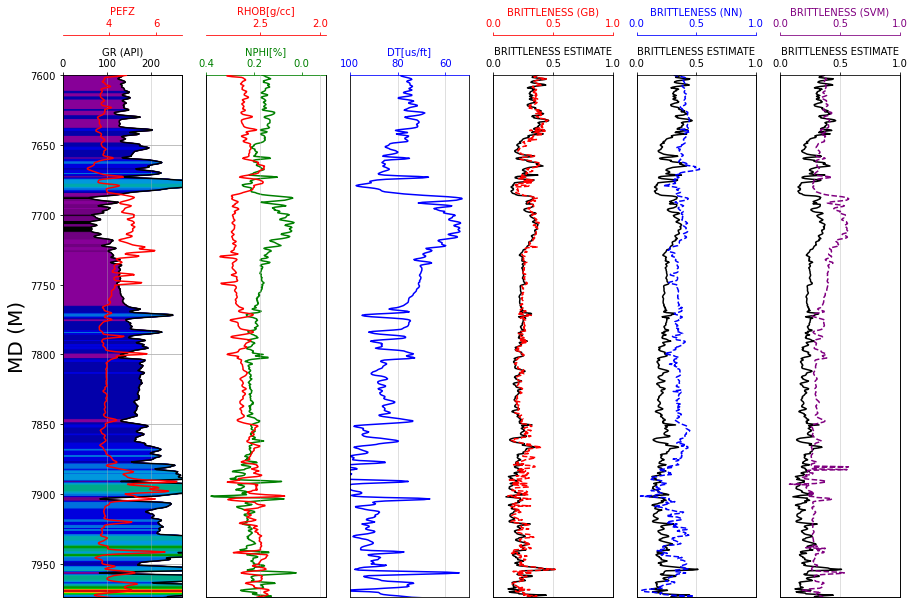

In [79]:
formation_bog = {'Upper Marcellus': [7877,7905],
             'Middle Marcellus': [7905, 7951],
            'Lower Marcellus': [7951,7974]}
plot_logs2(data_boggess, "Boggess", model_gb, model_svm, model_nn, formation_bog)

In [72]:
# # formation = {'Tully': [7195,7310],
# #              'Mahantango': [7310,7455],
# #             'Marcellus': [7455,7560]}

# formation = {'Upper Marcellus': [7453,7476],
#              'Middle Marcellus': [7476,7517],
#             'Lower Marcellus': [7517,7555]}
# plot_logs2(data_mip3h, "MIP3H2", model_gb, model_svm, model_nn, formation,)

In [50]:
# # formation2 = {'Tully': [7604,7670],
# #              'Mahantango': [7670,7882],
# #             'Marcellus': [7882,8052]}
# formation_pos = {'Upper Marcellus': [7883,7961],
#              'Middle Marcellus': [7961,8015],
#             'Lower Marcellus': [8015,8052]}
# plot_logs2(data_poseidon, "Poseidon", model_gb, model_svm, model_nn, formation_pos)

In [75]:
# formation_whip = {'Upper Marcellus': [7736, 7785],
#              'Middle Marcellus': [7785, 7811],
#             'Lower Marcellus': [7811, 7835]}
# plot_logs2(data_whipkey, "Whipkey", model_gb, model_svm, model_nn, formation_whip)